<a href="https://colab.research.google.com/github/Lemon-Aki/DeepLearningFromScratch1/blob/main/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#합성곱 신경망(convolutional neural network,CNN)
#합성곱 계층(convolutional layer):
#풀링 계층(pooling layer):
#완전연결 : 인접한 계층의 모든 뉴런과 연결되어 있는 방식
#완전연결계층(Affine 계층)으로 이루어진 연결망 r
#입력데이터 -> Affine계층 -> ReLU계층(활성화함수) -> ・・・ -> Affine계층 -> softmax계층(출력층) -> 최종 결과(확률)
#CNN 계층 : 출력에 가까운 층에서는 Affine-ReLU 구성이 사용 가능
#입력데이터 -> 합성곱계층(Conv) -> ReLU계층(활성화함수) -> 풀링계층 -> ・・・ -> 
#Affine계층 -> ReLU계층(활성화함수) -> Affine계층 -> softmax계층(출력층) -> 최종 결과(확률)
#완전연결 계층의 문제 : 데이터의 형상이 무시(이미지(3차원)를 1차원 데이터로 바꾸는 등)되기 때문에, 3차원에서 갖는 특징, 패턴등 정보가 사라짐
#합성곱 계층은 입력으로 받은 데이터의 형상을 그대로 출력함
#특징 맵(feature map): 합성곱 계층의 입출력 데이터
#합성곱 연산(필터 연산) : 필터의 윈도우를 일정 간격으로 이동해가면 입력데이터에 적용, 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 저장(단일 곱셈-누산,FMA)
#패딩(Padding): 입력 데이터 주변을 특정 값으로 채움, 합성곱 연산을 반복하다보면 출력 크기가 입력크기보다 줄어들기때문에, 출력 크기를 조정할 목적으로 사용
#스트라이드(stride): 윈도우를 몇칸씩 이동시킬까를 결정
#입력크기(H,W), 필터크기(FH,FW), 출력 크기(OH, OW), 패딩(P), 스트라이드(S)일때
#출력 크기 : OH = ((H+2P-FH)/s) + 1, OH = ((W+2P-FW)/s) + 1
#3차원 합성곱 연산 : 채널이 여러개일 경우, 입력 데이터와 필터의 합성곱 연산을 채널마다 수행하고, 그 결과를 더함, 입력 데이터의 채널수 = 필터의 채널수
#풀링 계층 : 세로/가로 방향의 공간을 줄이는 연산, 단순 연산이기 때문에 학습해야할 매개변수가 없고, 채널수가 변하지 않음, 입력의 변화에 따른 영향이 적음
#최대 풀링 : 지정된 대상 영역에서 최댓값을 구하는 연산

In [1]:
# 코랩과 구글드라이드를 연동(인증 필요)
#Transport endpoint is not connected 에러시 코랩 재연결
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive/DeepLearningFromScratch1/

Mounted at /gdrive
/gdrive/MyDrive/DeepLearningFromScratch1


In [6]:
#10개 데이터, 1채널, 28높이, 28너비
import numpy as np
x = np.random.rand(10, 1, 28, 28)
x.shape
#x[0,0]

(10, 1, 28, 28)

In [9]:
#im2col함수 : 입력 데이터를 필터링 하기 좋게 전개하는 함수(4차원 데이터를 2차원 행렬로 바꾸는 등)
#im2col 단점 : 필터의 적용 영역이 겹치는 경우가 대부분이기 대문에, 필터 적용 영역이 겹치면 전개후 원소 수가 원래 블록 원소 수 보다 많아짐
#합성곱 연산의 필터 처리 과정 : im2col에 통과한 입력데이터와 세로 1열로 전개한 필터를 행렬곱연산 후(결과:2차원) reshape(2차원->4차원)
#im2col함수 구조 : im2col(input_data, filter_h, filter_w, stride=1, pad=0)
#im2col함수 구조 : im2col(입력데이터(데이터수, 채널수, 높이, 너비의 4차원배열), 필터의 높이, 필터의 너비, 스트라이드, 패딩)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [19]:
#합성곱 계층 구현
class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    #필터(가중치), 편향, 스트라이드, 패딩 초기화
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
    out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

    col = im2col(x, FH, FW, self.stride, self.pad)
    #reshape의 -1 : 다차원 배열의 원소 수가 변환 후에도 똑같이 유지 되도록 묶어줌
    #예 : 10 *3 * 5 *5 =750개 원소를 reshape(10,-1)로 부르면 10묶음, 즉 (10,75)로 묶어줌
    col_W = self.W.reshape(FN, -1).T
    out = np.dot(col, col_W) + self.b

    #transpose함수 : 다차원 배열의 축 순서를 지정한 인덱스에 따라 바꿔줌(아래에선 N, -1(채널수), out_h, out_w 순으로 변경)
    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

    return out

  def backward(self, dout):
    FN, C, FH, FW = self.W.shape
    dout = dout.transpose(0,2,3,1).reshape(-1, FN)

    self.db = np.sum(dout, axis=0)
    self.dW = np.dot(self.col.T, dout)
    self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

    dcol = np.dot(dout, self.col_W.T)
    dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

    return dx

In [20]:
#풀링 계층 구현
#입력 데이터를 전개한다 -> 행별 최댓값을 구한다 -> 적절한 모양으로 성형한다
class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int(1 + (H - self.pool_h) / self.stride)
    out_w = int(1 + (W - self.pool_w) / self.stride)

    #전개
    col = im2col(x, self.pool_h, self.pool_w, self.stride, self,pad)
    col = col.reshape(-1, self.pool_h*self.pool_w)
    
    #최댓값구하기
    out = np.max(col, axis=1)

    #성형
    out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

    return out

  def backward(self, dout):
    dout = dout.transpose(0, 2, 3, 1)
        
    pool_size = self.pool_h * self.pool_w
    dmax = np.zeros((dout.size, pool_size))
    dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
    dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
    dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
    dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
    return dx

In [45]:
#CNN 구현하기(총3층 : 합성곱계층 -> 완전연결계층(ReLU활성화) -> 완전연결계층(softmax출력))
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
from common import util
class SimpleConvNet:
  def __init__(self, input_dim=(1,28,28), conv_param={'filter_num':30, 'filter_size':5,'pad':0, 'stride':1},
               hidden_size=100, output_size=10, weight_init_std=0.01):
    #합성곱 계층의 하이퍼파라미터 초기화
    filter_num = conv_param['filter_num']
    filter_size = conv_param['filter_size']
    filter_pad = conv_param['pad']
    filter_stride = conv_param['stride']
    input_size = input_dim[1]
    conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
    pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

    #가중치 매개변수 초기화
    #W1,b1 : 합성곱계층, W2,b2 : 완전연결계층, W3,b3 : 완전연결계층
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
    #zeros : 0으로 가득찬 넘파이 배열 생성
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)

    #CNN 구성 계층 생성
    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
    self.layers['ReLu1'] = Relu()
    self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['ReLu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

    self.last_layer = SoftmaxWithLoss()
  
  #orderdict 계층 순서대로 추론 실행
  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    return x

  #predict의 결과와 정답 데이터를 마지막 층의 forward에 넘겨줘서 손실함수 값 구하기
  def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)

  #오차역전파법 구현
  def gradient(self, x, t):
    #순전파
    self.loss(x, t)

    #역전파
    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    #결과저장
    grads = {}
    grads['W1'] = self.layers['Conv1'].dW
    grads['b1'] = self.layers['Conv1'].db
    grads['W2'] = self.layers['Affine1'].dW
    grads['b2'] = self.layers['Affine1'].db
    grads['W3'] = self.layers['Affine2'].dW
    grads['b3'] = self.layers['Affine2'].db

    return grads
    
  def accuracy(self, x, t, batch_size=100):
    if t.ndim != 1 : t = np.argmax(t, axis=1)
        
    acc = 0.0
        
    for i in range(int(x.shape[0] / batch_size)):
      tx = x[i*batch_size:(i+1)*batch_size]
      tt = t[i*batch_size:(i+1)*batch_size]
      y = self.predict(tx)
      y = np.argmax(y, axis=1)
      acc += np.sum(y == tt) 
        
    return acc / x.shape[0]

train loss:2.299839839136071
=== epoch:1, train acc:0.255, test acc:0.213 ===
train loss:2.2983099719180826
train loss:2.292967088388422
train loss:2.2906965436514084
train loss:2.2784596548664773
train loss:2.2667281663372942
train loss:2.24827308312369
train loss:2.2201315539065973
train loss:2.201809187459049
train loss:2.172489773745075
train loss:2.144926384043697
train loss:2.123490451701578
train loss:2.1126692458922847
train loss:2.0169439422014013
train loss:1.964252594673411
train loss:1.8988889418535648
train loss:1.8467893436473373
train loss:1.653386698637396
train loss:1.6911475211843803
train loss:1.6251487151615394
train loss:1.525748423142937
train loss:1.3898296280023752
train loss:1.3529955761242531
train loss:1.1606814830593282
train loss:1.1814316803549028
train loss:1.1578338834363806
train loss:1.069679305031513
train loss:0.9499354765286563
train loss:0.910148249907629
train loss:0.968553512094384
train loss:0.8562752229288517
train loss:0.8756678756946648
train

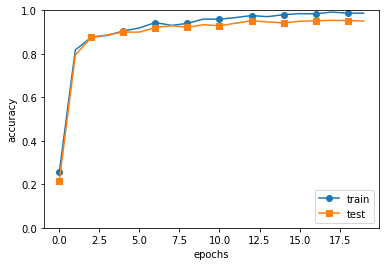

In [48]:
#CNN 훈련 실행
from dataset.mnist import load_mnist
from common.trainer import Trainer
import matplotlib.pyplot as plt

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
#network.save_params("params.pkl")
#print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()